In [1]:
import math
import warnings

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import linear_model
from sklearn.cross_decomposition import PLSRegression

%matplotlib inline
sns.set_style('white')

# Suppress annoying harmless error.
warnings.filterwarnings(
    action="ignore",
    module="scipy",
    message="^internal gelsd"
)

## Dimensionality Reduction in Linear Regression

Having a lot of features can cause problems. The more features in your regression the more complex the model, and the longer it takes to run.  Variance in the features that is unrelated to the outcome $Y$ may create noise in predictions (especially when that variance is shared among features in multicollinearity), and more features also means more unrelated variance and thus more noise.  Sometimes there may be more predictors than datapoints, leading to negative degrees of freedom and a model that won't run.  For these reasons, data scientists interested solely in building a prediction model (with no interest in interpreting the individual parameters) may turn to dimension reduction methods to simplify their feature space while retaining all the predictive power of the original model.

The idea is to reduce a matrix of features $X$ into a matrix with fewer columns $R(X)$ where the expected value of $Y$ given $X$ ($E(Y|X)$) is equal to the expected value of $Y$ given $R(X)$. We say "expected value" rather than "predicted value" to be consistent with the commonly-used mathematical notation, but the meaning is the same – we want a smaller set of features that will produce the same predicted values for $Y$ as our larger number of features.

If this is sounding a lot like PCA, you're right.  The difference is that instead of trying to reduce a set of $X$ into a smaller set $R(X)$ that contains all the variance in $X$, we are trying to reduce a set of $X$ into an $R(X)$ that contains all the variance in $X$ that is shared with $Y$.  


## Partial least squares regression

We call this method **partial least squares regression**, or "PLSR". As in PCA, PLSR is iterative. It first tries to find the vector within the $n$-dimensional space of $X$ with the highest covariance with $y$.  Then it looks for a second vector, perpendicular to the first, that explains the highest covariance with $y$ that remains after accounting for the first vector. This continues for as many components as we permit, up to $n$.

SciKit-learn has a function to run PLSR:

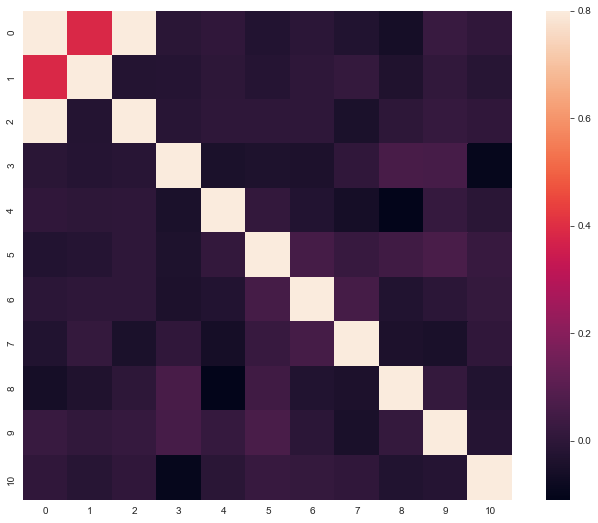

In [2]:
# Number of datapoints in outcome.
n = 1000

# Number of features.
p = 10

# Create random normally distributed data for parameters.
X = np.random.normal(size=n * p).reshape((n, p))

# Create normally distributed outcome related to parameters but with noise.
y = X[:, 0] + 2 * X[:, 1] + np.random.normal(size=n * 1) + 5



# Check out correlations. First column is the outcome.
f, ax = plt.subplots(figsize=(12, 9))
corrmat = pd.DataFrame(np.insert(X, 0, y, axis=1)).corr()

# Draw the heatmap using seaborn.
sns.heatmap(corrmat, vmax=.8, square=True)
plt.show()

In [3]:
X

array([[ 1.03645881,  0.43828619, -0.61694067, ..., -0.31152903,
        -0.90480688, -0.20248362],
       [-0.07305662,  0.24363268,  0.8721432 , ..., -0.43852316,
         0.88201049, -0.98930835],
       [ 0.10027526,  0.44357316, -0.33798995, ...,  1.3854575 ,
        -0.26555599, -1.06037543],
       ...,
       [-1.17512987,  0.82079786, -1.74084758, ..., -2.77709243,
         1.25858132, -0.60850743],
       [-0.68594295, -0.01228055, -0.27399006, ..., -0.41936268,
         1.35262194, -0.58310297],
       [ 0.68880539,  0.06902507,  1.9274229 , ..., -2.03095343,
         0.25333853,  0.67161204]])

In [4]:
X.shape

(1000, 10)

In [5]:
y

array([ 6.09611426,  6.85211689,  5.86556104, 11.11910554,  4.41818302,
        2.50538667,  2.91669715,  3.4176492 ,  3.93391627,  3.10874444,
        5.65338625,  5.4481768 ,  1.17860929,  4.62814632,  8.5240489 ,
        6.25568474,  2.02688181,  8.55200389,  1.09581849,  0.2649332 ,
        3.76967669,  2.27177841,  7.57741558,  6.95932261,  3.81661543,
        2.30050078,  7.63570007,  3.49006717,  3.31901091,  6.12997237,
        4.22583466,  3.73809461,  8.59174228,  4.19287054,  3.00640821,
        6.01070492, -0.53353552,  4.55417898,  1.6809953 ,  2.03158699,
        6.80325053,  3.3307234 ,  7.35084148,  3.22794291,  5.95425524,
        5.33112501,  4.96949219,  5.71473705,  2.44311132,  8.69796352,
        5.16110397,  4.0360188 ,  4.04211078,  7.91780318,  3.71992749,
        5.2157269 ,  5.23229605,  7.93885722,  0.67670762,  4.25567223,
        4.86957898,  1.70354962,  3.6917592 ,  7.98072128,  3.99803212,
        5.42453545,  5.82252704,  7.82446028,  5.20780036,  4.57

In [6]:
y.shape

(1000,)

([array([  2.,  13.,  57., 149., 264., 299., 156.,  49.,   9.,   2.]),
  array([  3.,  11.,  58., 148., 283., 300., 135.,  51.,  10.,   1.]),
  array([  4.,  11.,  59., 159., 282., 275., 145.,  60.,   5.,   0.]),
  array([  2.,  10.,  57., 170., 315., 244., 146.,  46.,  10.,   0.]),
  array([  2.,   9.,  60., 178., 237., 292., 152.,  60.,   7.,   3.]),
  array([  1.,  12.,  52., 191., 274., 261., 146.,  53.,   8.,   2.]),
  array([  0.,   8.,  66., 159., 278., 279., 159.,  41.,   9.,   1.]),
  array([  1.,  15.,  77., 156., 294., 261., 139.,  45.,  10.,   2.]),
  array([  4.,   3.,  43., 158., 297., 320., 127.,  40.,   5.,   3.]),
  array([  3.,   9.,  53., 186., 296., 250., 159.,  33.,   9.,   2.])],
 array([-3.75474532, -2.99210096, -2.2294566 , -1.46681224, -0.70416788,
         0.05847647,  0.82112083,  1.58376519,  2.34640955,  3.10905391,
         3.87169827]),
 <a list of 10 Lists of Patches objects>)

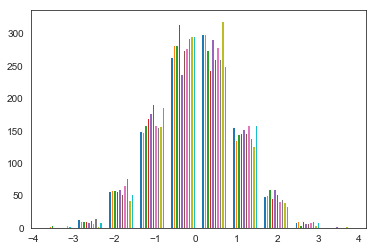

In [7]:
plt.hist(X)

(array([  8.,  30.,  85., 151., 229., 249., 132.,  80.,  29.,   7.]),
 array([-1.99374968, -0.55932494,  0.87509981,  2.30952455,  3.7439493 ,
         5.17837404,  6.61279879,  8.04722353,  9.48164828, 10.91607302,
        12.35049776]),
 <a list of 10 Patch objects>)

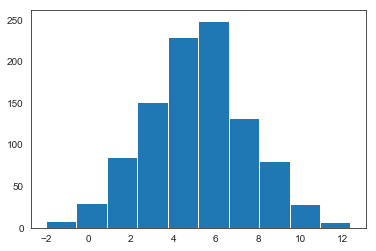

In [8]:
plt.hist(y)

R-squared regression: 0.8426026033713112
R-squared PLSR: 0.8426024905340752


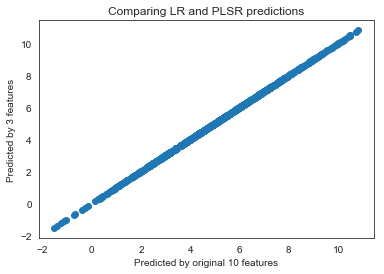

In [9]:
# Fit a linear model with all 10 features.
regr = linear_model.LinearRegression()
regr.fit(X, y)

# Save predicted values.
Y_pred = regr.predict(X)
print('R-squared regression:', regr.score(X, y))

# Fit a linear model using Partial Least Squares Regression.
# Reduce feature space to 3 dimensions.
pls1 = PLSRegression(n_components=3)

# Reduce X to R(X) and regress on y.
pls1.fit(X, y)

# Save predicted values.
Y_PLS_pred = pls1.predict(X)
print('R-squared PLSR:', pls1.score(X, y))

# Compare the predictions of the two models
plt.scatter(Y_pred,Y_PLS_pred) 
plt.xlabel('Predicted by original 10 features')
plt.ylabel('Predicted by 3 features')
plt.title('Comparing LR and PLSR predictions')
plt.show()

PLSR will not work as well if features are uncorrelated, or if the only feature correlations are paired (feature 1 is only correlated with feature 2, feature 3 is only correlated with feature 4, etc).

The trick to successful PLSR is to select the right number of components to keep.  Use the cell below to create new partial least square regressions with different numbers of components, then see how those changes affect the ability of your models to reproduce the predicted Y values as well as the regular linear regression.  Typically, you would choose your components based on the number that gives the most consistent performance between training and test datasets.

Since this data is randomly generated, you can also play with it by changing how $y$ is computed, then observing how different relationships between $y$ and $X$ play out in PLSR.

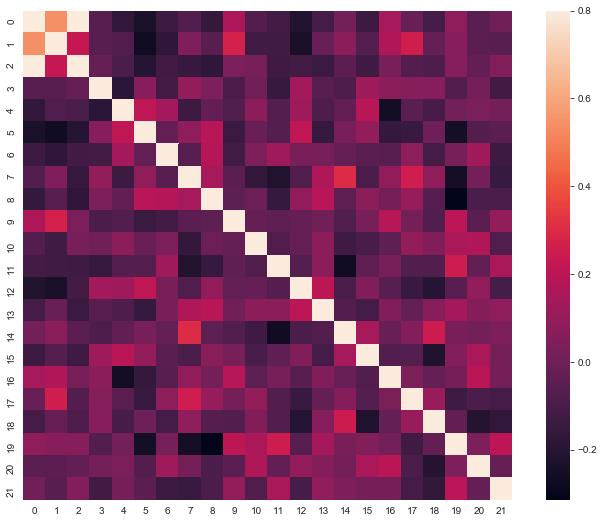

In [10]:
# Your PLSR models here.
#Number of datapoints in outcome
num = 73

#Number of features
feat=21

#Create random normally distributed data for parameters.
X_ran = np.random.normal(size=num*feat).reshape((num,feat))

#Create normally distributed outcome related to parameters but w/ noise.
y_noise = X_ran[:, 0] + 2*X_ran[:, 1] + np.random.normal(size = num*1) + 5

#Check out correlations. First column is the outcome.
f, ax = plt.subplots(figsize=(12, 9))
corrmat = pd.DataFrame(np.insert(X_ran, 0, y_noise, axis=1)).corr()

#Draw the heatmap using the seaborn
sns.heatmap(corrmat, vmax=.8, square = True)
plt.show()



R-squared regression:  0.9189225483744583
R-squared PLSR: 0.916349466962937


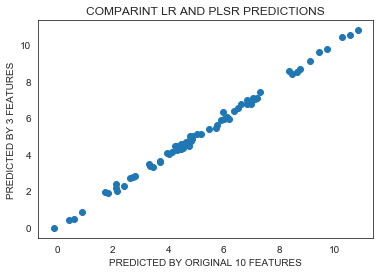

In [11]:
# Fit a linear model with all 10 features.
regr = linear_model.LinearRegression()
regr.fit(X_ran, y_noise)

#Save predicted values.
Y_pred = regr.predict(X_ran)
print('R-squared regression: ', regr.score(X_ran, y_noise))

#Fit a linear model using Partial least Squares Regression.
#Reduce feature space to 3 dimensions.
pls1 = PLSRegression(n_components=3)

#Reduce X to R(X) and regress on y.
pls1.fit(X_ran, y_noise)

#Save predicted values.
Y_PLS_pred = pls1.predict(X_ran)
print('R-squared PLSR:', pls1.score(X_ran, y_noise))

#Comparing the predictions of the two models
plt.scatter(Y_pred, Y_PLS_pred)
plt.xlabel('PREDICTED BY ORIGINAL 10 FEATURES')
plt.ylabel('PREDICTED BY 3 FEATURES')
plt.title('COMPARINT LR AND PLSR PREDICTIONS')
plt.show()

([array([ 0.,  0.,  1.,  3., 17., 26., 19.,  7.,  0.,  0.]),
  array([ 0.,  1.,  0.,  7., 18., 26., 15.,  4.,  2.,  0.]),
  array([ 1.,  0.,  0.,  6., 17., 24., 14.,  8.,  2.,  1.]),
  array([ 0.,  0.,  2.,  5., 15., 20., 26.,  4.,  1.,  0.]),
  array([ 1.,  0.,  0.,  9.,  5., 29., 23.,  6.,  0.,  0.]),
  array([ 0.,  0.,  4.,  7., 16., 19., 15.,  9.,  2.,  1.]),
  array([ 0.,  0.,  0.,  9., 15., 26., 15.,  7.,  1.,  0.]),
  array([ 0.,  0.,  4.,  8., 21., 22., 11.,  6.,  1.,  0.]),
  array([ 0.,  0.,  0.,  7., 20., 26., 14.,  5.,  1.,  0.]),
  array([ 0.,  0.,  0.,  6., 18., 21., 17.,  8.,  2.,  1.]),
  array([ 0.,  0.,  0., 12., 17., 22., 16.,  6.,  0.,  0.]),
  array([ 0.,  0.,  0.,  5., 22., 29., 10.,  4.,  3.,  0.]),
  array([ 0.,  0.,  2.,  8., 20., 21., 19.,  3.,  0.,  0.]),
  array([ 0.,  0.,  2.,  5., 22., 18., 14., 10.,  2.,  0.]),
  array([ 0.,  0.,  1.,  6., 17., 22., 20.,  5.,  1.,  1.]),
  array([ 0.,  0.,  0.,  7., 22., 20., 14.,  9.,  1.,  0.]),
  array([ 0.,  0.,  3., 

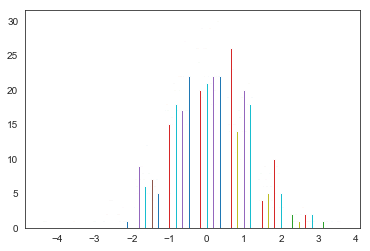

In [12]:
plt.hist(X_ran)

(array([ 5.,  5.,  9., 16., 15., 10.,  5.,  1.,  6.,  1.]),
 array([ 0.37234404,  1.51171631,  2.65108857,  3.79046084,  4.92983311,
         6.06920537,  7.20857764,  8.3479499 ,  9.48732217, 10.62669443,
        11.7660667 ]),
 <a list of 10 Patch objects>)

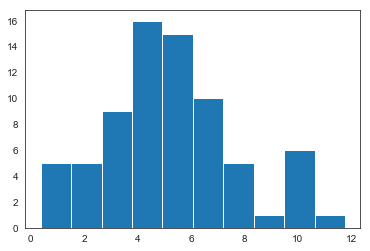

In [13]:
plt.hist(y_noise)